In [ ]:
# Akbank Makine Öğrenmesi Bootcamp - Airbnb Fiyat Tahmin Projesi
# Random Forest Regressor ile Airbnb Fiyat Tahmini - FIXED VERSION

# Ferhat Onur Özgan - Berke Kabasakal

# =================== KÜTÜPHANE İMPORTLARI ===================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Model kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8')  
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("🚀 Airbnb Fiyat Tahmin Projesi - Random Forest ile (FIXED)")
print("=" * 60)

🚀 Airbnb Fiyat Tahmin Projesi - Random Forest ile (FIXED)


In [2]:

# =================== VERİ YÜKLEME VE İLK İNCELEME ===================
print("\n📊 VERİ YÜKLEME VE İLK İNCELEME")
print("-" * 40)

# Veriyi yükle
df = pd.read_csv('/kaggle/input/airbnbopendata/Airbnb_Open_Data.csv')

print(f"✅ Veri başarıyla yüklendi!")
print(f"📈 Veri seti boyutu: {df.shape[0]} satır, {df.shape[1]} sütun")
print(f"💾 Veri seti boyutu: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Veri setinin boyut kontrolü (PDF gereksinimi: >10MB veya >10k kayıt)
if df.shape[0] > 10000:
    print(f"✅ Veri seti kayıt sayısı gereksinimi karşılanıyor: {df.shape[0]} > 10,000")
elif df.memory_usage(deep=True).sum() / 1024**2 > 10:
    print(f"✅ Veri seti boyut gereksinimi karşılanıyor: {df.memory_usage(deep=True).sum() / 1024**2:.2f}MB > 10MB")

print("\n🔍 İlk 5 satır:")
print(df.head())

print("\n📋 Veri Türleri ve Eksik Değer Analizi:")
info_df = pd.DataFrame({
    'Veri_Tipi': df.dtypes,
    'Eksik_Değer': df.isnull().sum(),
    'Eksik_Oran_%': (df.isnull().sum() / len(df) * 100).round(2)
})
print(info_df[info_df['Eksik_Değer'] > 0])


📊 VERİ YÜKLEME VE İLK İNCELEME
----------------------------------------
✅ Veri başarıyla yüklendi!
📈 Veri seti boyutu: 102599 satır, 26 sütun
💾 Veri seti boyutu: 114.37 MB
✅ Veri seti kayıt sayısı gereksinimi karşılanıyor: 102599 > 10,000

🔍 İlk 5 satır:
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Har



🔬 KEŞİFSEL VERİ ANALİZİ (EDA)
----------------------------------------
💰 Fiyat İstatistikleri:
count    102599.000000
mean        623.788185
std         332.686420
min           0.000000
25%         337.000000
50%         623.000000
75%         912.000000
max        1200.000000
Name: price_cleaned, dtype: float64

🧹 Sıfır fiyatlı kayıtlar temizlendi. Kalan kayıt sayısı: 102352


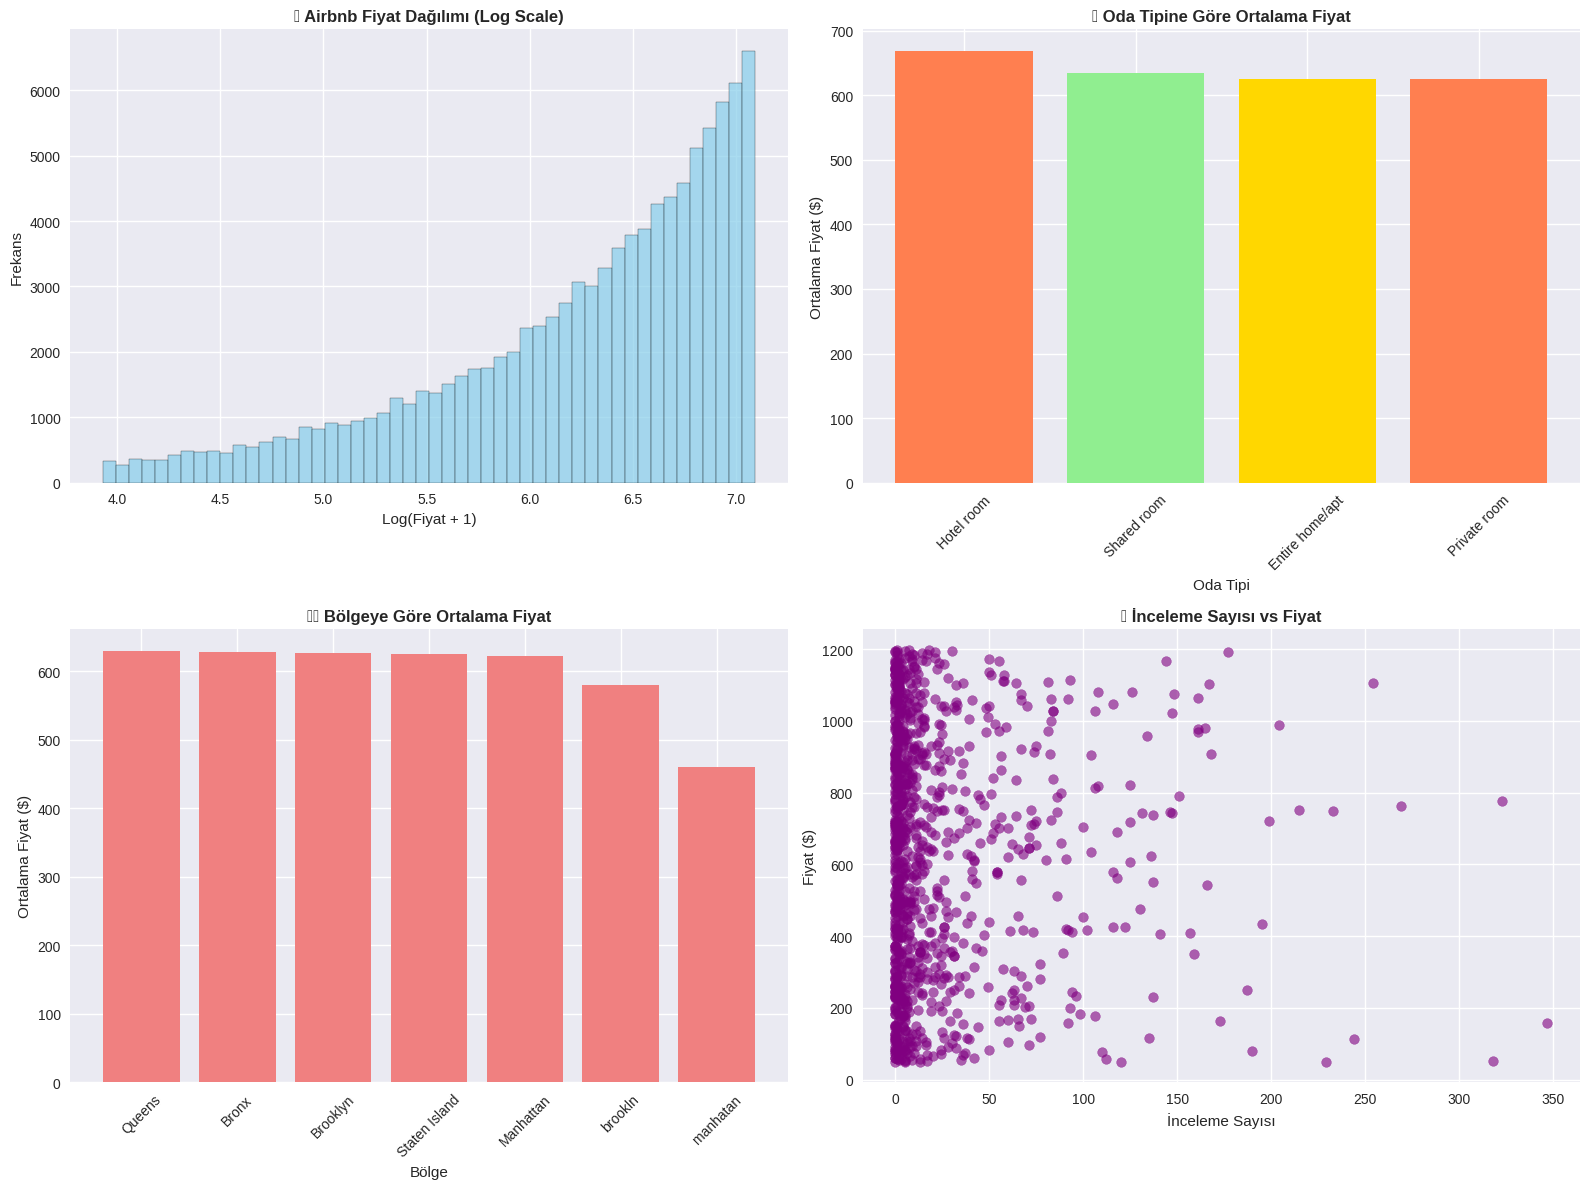


📊 Sayısal değişkenler arası korelasyon:


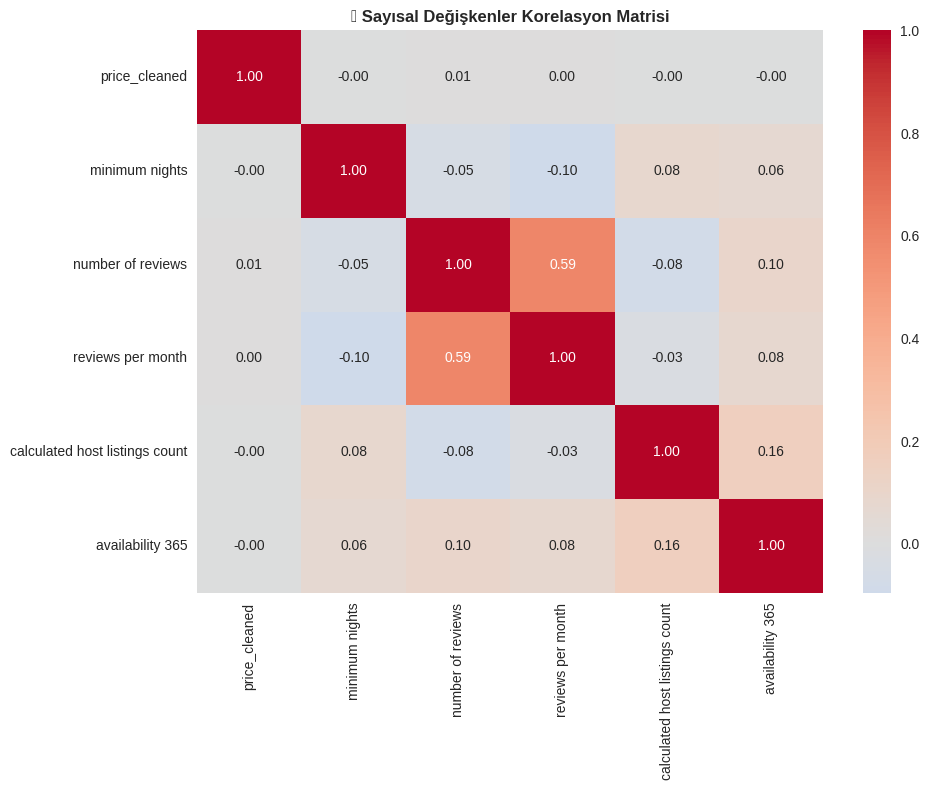

In [3]:
# =================== KEŞİFSEL VERİ ANALİZİ (EDA) ===================
print("\n\n🔬 KEŞİFSEL VERİ ANALİZİ (EDA)")
print("-" * 40)

# Fiyat sütununu temizle ve sayısal hale getir
def clean_price(price_str):
    """Fiyat string'ini sayısal değere çevirir"""
    if pd.isna(price_str):
        return 0.0
    
    cleaned = str(price_str).replace('$', '').replace(',', '').replace(' ', '')
    try:
        value = float(cleaned)
        return max(0.0, value)
    except:
        return 0.0

df['price_cleaned'] = df['price'].apply(clean_price)
df['service_fee_cleaned'] = df['service fee'].apply(clean_price)

print("💰 Fiyat İstatistikleri:")
print(df['price_cleaned'].describe())

# Sıfır fiyatlı kayıtları çıkar
df = df[df['price_cleaned'] > 0]
print(f"\n🧹 Sıfır fiyatlı kayıtlar temizlendi. Kalan kayıt sayısı: {len(df)}")

# EDA Görselleştirmeleri
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Fiyat dağılımı (log scale)
axes[0,0].hist(np.log1p(df['price_cleaned']), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('🏠 Airbnb Fiyat Dağılımı (Log Scale)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Log(Fiyat + 1)')
axes[0,0].set_ylabel('Frekans')

# 2. Oda tipine göre fiyat
room_price = df.groupby('room type')['price_cleaned'].mean().sort_values(ascending=False)
axes[0,1].bar(room_price.index, room_price.values, color=['coral', 'lightgreen', 'gold'])
axes[0,1].set_title('🏡 Oda Tipine Göre Ortalama Fiyat', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Oda Tipi')
axes[0,1].set_ylabel('Ortalama Fiyat ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Bölgeye göre fiyat
neighborhood_price = df.groupby('neighbourhood group')['price_cleaned'].mean().sort_values(ascending=False)
axes[1,0].bar(neighborhood_price.index, neighborhood_price.values, color='lightcoral')
axes[1,0].set_title('🗺️ Bölgeye Göre Ortalama Fiyat', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Bölge')
axes[1,0].set_ylabel('Ortalama Fiyat ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. İnceleme sayısı vs Fiyat (sample alarak)
sample_data = df.sample(min(1000, len(df)), random_state=42)
axes[1,1].scatter(sample_data['number of reviews'], sample_data['price_cleaned'], 
                 alpha=0.6, color='purple')
axes[1,1].set_title('📝 İnceleme Sayısı vs Fiyat', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('İnceleme Sayısı')
axes[1,1].set_ylabel('Fiyat ($)')

plt.tight_layout()
plt.show()

# Korelasyon matrisi
print("\n📊 Sayısal değişkenler arası korelasyon:")
numeric_cols = ['price_cleaned', 'minimum nights', 'number of reviews', 
                'reviews per month', 'calculated host listings count', 'availability 365']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('🔗 Sayısal Değişkenler Korelasyon Matrisi', fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:

# =================== VERİ ÖN İŞLEME ===================
print("\n\n🔧 VERİ ÖN İŞLEME")
print("-" * 40)

# Yeni DataFrame oluştur
df_processed = df.copy()

# Aykırı değerleri temizle
def remove_outliers_iqr(df, column):
    """IQR yöntemi ile aykırı değerleri temizle"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print("🧹 Aykırı değerler temizleniyor...")
initial_size = len(df_processed)
df_processed = remove_outliers_iqr(df_processed, 'price_cleaned')
print(f"   Fiyat aykırı değerleri: {initial_size - len(df_processed)} kayıt kaldırıldı")

# Eksik değerleri doldur
print("\n🔄 Eksik değerler dolduruluyor...")

# Kategorik değişkenler için mod ile doldur
categorical_columns = ['host_identity_verified', 'neighbourhood group', 
                      'instant_bookable', 'cancellation_policy', 'room type']

for col in categorical_columns:
    if col in df_processed.columns:
        mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'unknown'
        df_processed[col] = df_processed[col].fillna(mode_value)
        print(f"   {col}: {mode_value} ile dolduruldu")

# Sayısal değişkenler için medyan ile doldur
numerical_columns = ['minimum nights', 'number of reviews', 'reviews per month', 
                    'calculated host listings count', 'availability 365', 'Construction year']

for col in numerical_columns:
    if col in df_processed.columns:
        median_value = df_processed[col].median()
        df_processed[col] = df_processed[col].fillna(median_value)
        print(f"   {col}: {median_value} ile dolduruldu")

# Özellik mühendisliği
print("\n⚙️ Yeni özellikler oluşturuluyor...")

# Yaş hesaplama (Construction year'dan)
current_year = 2023
df_processed['house_age'] = current_year - df_processed['Construction year']
df_processed['house_age'] = df_processed['house_age'].clip(0, 200)  # Mantıklı sınırlar

# İnceleme yoğunluğu - SIFIRLA BÖLME HATASI ÇÖZÜLDİ
df_processed['review_density'] = df_processed['number of reviews'] / (df_processed['availability 365'] + 1)

# Konum bazlı özellikler
df_processed['is_manhattan'] = (df_processed['neighbourhood group'] == 'Manhattan').astype(int)
df_processed['is_brooklyn'] = (df_processed['neighbourhood group'] == 'Brooklyn').astype(int)

# Hizmet ücreti oranı - SIFIRLA BÖLME HATASI ÇÖZÜLDİ
df_processed['service_fee_ratio'] = df_processed['service_fee_cleaned'] / (df_processed['price_cleaned'] + 1)

print(f"   Yeni özellikler eklendi: house_age, review_density, location features, service_fee_ratio")

# Kategorik değişkenleri encode et
print("\n🔤 Kategorik değişkenler encode ediliyor...")
label_encoders = {}

for feature in categorical_columns:
    if feature in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature].astype(str))
        label_encoders[feature] = le
        print(f"   {feature} encode edildi")

# Feature selection için özellikler
feature_columns = [
    'minimum nights', 'number of reviews', 'reviews per month', 
    'calculated host listings count', 'availability 365', 'house_age',
    'review_density', 'service_fee_ratio', 'is_manhattan', 'is_brooklyn',
    'neighbourhood group_encoded', 'room type_encoded', 
    'host_identity_verified_encoded', 'instant_bookable_encoded',
    'cancellation_policy_encoded'
]

# Mevcut sütunları filtrele
available_features = [col for col in feature_columns if col in df_processed.columns]
X = df_processed[available_features]
y = df_processed['price_cleaned']

# Son temizlik
X = X.fillna(X.median())
y = y.fillna(y.median())



🔧 VERİ ÖN İŞLEME
----------------------------------------
🧹 Aykırı değerler temizleniyor...
   Fiyat aykırı değerleri: 0 kayıt kaldırıldı

🔄 Eksik değerler dolduruluyor...
   host_identity_verified: unconfirmed ile dolduruldu
   neighbourhood group: Manhattan ile dolduruldu
   instant_bookable: False ile dolduruldu
   cancellation_policy: moderate ile dolduruldu
   room type: Entire home/apt ile dolduruldu
   minimum nights: 3.0 ile dolduruldu
   number of reviews: 7.0 ile dolduruldu
   reviews per month: 0.74 ile dolduruldu
   calculated host listings count: 1.0 ile dolduruldu
   availability 365: 96.0 ile dolduruldu
   Construction year: 2012.0 ile dolduruldu

⚙️ Yeni özellikler oluşturuluyor...
   Yeni özellikler eklendi: house_age, review_density, location features, service_fee_ratio

🔤 Kategorik değişkenler encode ediliyor...
   host_identity_verified encode edildi
   neighbourhood group encode edildi
   instant_bookable encode edildi
   cancellation_policy encode edildi
   room

In [5]:
# =================== KRİTİK: INFINITY VE NAN DEĞERLERİNİ TEMİZLE ===================
print("\n🚨 INFINITY VE NAN DEĞERLERİ TEMİZLENİYOR...")

# Infinity değerlerini kontrol et ve temizle
print("   Infinity değerleri kontrol ediliyor...")
inf_cols = []
for col in X.columns:
    if np.isinf(X[col]).any():
        inf_count = np.isinf(X[col]).sum()
        print(f"   🔍 {col}: {inf_count} infinity değeri bulundu")
        inf_cols.append(col)
        
        # Infinity değerlerini sütunun medyanı ile değiştir
        median_val = X[col][~np.isinf(X[col])].median()
        X.loc[np.isinf(X[col]), col] = median_val
        print(f"   ✅ {col}: Infinity değerleri {median_val} ile değiştirildi")

# NaN değerlerini kontrol et ve temizle
print("   NaN değerleri kontrol ediliyor...")
nan_cols = []
for col in X.columns:
    if X[col].isna().any():
        nan_count = X[col].isna().sum()
        print(f"   🔍 {col}: {nan_count} NaN değeri bulundu")
        nan_cols.append(col)
        
        # NaN değerlerini sütunun medyanı ile değiştir
        median_val = X[col].median()
        X.loc[X[col].isna(), col] = median_val
        print(f"   ✅ {col}: NaN değerleri {median_val} ile değiştirildi")

# Çok büyük değerleri kontrol et ve temizle
print("   Çok büyük değerler kontrol ediliyor...")
for col in X.columns:
    max_val = X[col].max()
    if max_val > 1e6:  # 1 milyon üzerindeki değerler
        print(f"   🔍 {col}: Maximum değer {max_val}")
        
        # 99.9 percentile ile cap uygula
        cap_value = X[col].quantile(0.999)
        X.loc[X[col] > cap_value, col] = cap_value
        print(f"   ✅ {col}: {cap_value} ile sınırlandırıldı")

# Target değişkeni de kontrol et
if np.isinf(y).any():
    print("   🔍 Target değişkende infinity değeri bulundu, temizleniyor...")
    y = y[~np.isinf(y)]
    X = X.loc[y.index]

if y.isna().any():
    print("   🔍 Target değişkende NaN değeri bulundu, temizleniyor...")
    valid_indices = ~y.isna()
    y = y[valid_indices]
    X = X.loc[valid_indices]

# Final kontrol
print(f"\n✅ Final veri seti: {X.shape[0]} satır, {X.shape[1]} özellik")
print(f"📊 Kullanılan özellikler: {list(X.columns)}")

# Veri tiplerini kontrol et ve float32'ye çevir
print("   Veri tipleri float32'ye çevriliyor...")
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        X[col] = X[col].astype('float32')

print("✅ Tüm infinity, NaN ve büyük değer problemleri çözüldü!")


🚨 INFINITY VE NAN DEĞERLERİ TEMİZLENİYOR...
   Infinity değerleri kontrol ediliyor...
   🔍 review_density: 31 infinity değeri bulundu
   ✅ review_density: Infinity değerleri 0.13496932515337423 ile değiştirildi
   NaN değerleri kontrol ediliyor...
   Çok büyük değerler kontrol ediliyor...

✅ Final veri seti: 102352 satır, 15 özellik
📊 Kullanılan özellikler: ['minimum nights', 'number of reviews', 'reviews per month', 'calculated host listings count', 'availability 365', 'house_age', 'review_density', 'service_fee_ratio', 'is_manhattan', 'is_brooklyn', 'neighbourhood group_encoded', 'room type_encoded', 'host_identity_verified_encoded', 'instant_bookable_encoded', 'cancellation_policy_encoded']
   Veri tipleri float32'ye çevriliyor...
✅ Tüm infinity, NaN ve büyük değer problemleri çözüldü!


In [6]:

# =================== MODEL EĞİTİMİ VE DEĞERLENDİRME ===================
print("\n\n🤖 RANDOM FOREST MODEL EĞİTİMİ")
print("-" * 40)

# Veriyi train-test olarak böl
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Eğitim seti: {X_train.shape[0]} kayıt")
print(f"📊 Test seti: {X_test.shape[0]} kayıt")

# Önce basit Random Forest dene
print("\n🌳 Temel Random Forest modeli eğitiliyor...")
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

try:
    rf_base.fit(X_train, y_train)
    print("✅ Model başarıyla eğitildi!")
    
    # Temel model performance
    y_pred_base = rf_base.predict(X_test)
    base_r2 = r2_score(y_test, y_pred_base)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
    base_mae = mean_absolute_error(y_test, y_pred_base)
    
    print(f"📈 Temel Random Forest Performansı:")
    print(f"   R² Score: {base_r2:.4f}")
    print(f"   RMSE: ${base_rmse:.2f}")
    print(f"   MAE: ${base_mae:.2f}")
    
    # Cross-validation
    cv_scores = cross_val_score(rf_base, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    print(f"   Cross-Validation R²: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")

except Exception as e:
    print(f"❌ Model eğitimi hatası: {e}")
    print("🔍 Veri kalitesi tekrar kontrol ediliyor...")
    
    # Son kontrol
    print(f"   X'de infinity: {np.isinf(X_train).any().any()}")
    print(f"   X'de NaN: {X_train.isna().any().any()}")
    print(f"   y'de infinity: {np.isinf(y_train).any()}")
    print(f"   y'de NaN: {y_train.isna().any()}")
    raise



🤖 RANDOM FOREST MODEL EĞİTİMİ
----------------------------------------
📊 Eğitim seti: 81881 kayıt
📊 Test seti: 20471 kayıt

🌳 Temel Random Forest modeli eğitiliyor...
✅ Model başarıyla eğitildi!
📈 Temel Random Forest Performansı:
   R² Score: 0.7749
   RMSE: $157.61
   MAE: $85.64
   Cross-Validation R²: 0.7549 (±0.0124)


In [7]:
# =================== HİPERPARAMETRE OPTİMİZASYONU ===================
print("\n\n⚡ HİPERPARAMETRE OPTİMİZASYONU")
print("-" * 40)

print("🔧 Grid Search ile hiperparametre optimizasyonu...")

# Daha küçük hiperparametre grid'i (hız için)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']
}


# Grid Search
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,  # Daha hızlı için 3 fold
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("⏱️ Grid Search başlatılıyor...")
rf_grid.fit(X_train, y_train)

print(f"\n✅ En iyi parametreler: {rf_grid.best_params_}")
print(f"📊 En iyi CV R² skoru: {rf_grid.best_score_:.4f}")

# En iyi modeli al
best_rf = rf_grid.best_estimator_



⚡ HİPERPARAMETRE OPTİMİZASYONU
----------------------------------------
🔧 Grid Search ile hiperparametre optimizasyonu...
⏱️ Grid Search başlatılıyor...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ En iyi parametreler: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
📊 En iyi CV R² skoru: 0.5686


In [8]:
# =================== FINAL MODEL DEĞERLENDİRME ===================
print("\n\n📊 FINAL MODEL DEĞERLENDİRME")
print("-" * 40)

# Test seti üzerinde tahmin
y_pred_final = best_rf.predict(X_test)

# Metrikleri hesapla
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)
final_mse = mean_squared_error(y_test, y_pred_final)

print(f"🎯 OPTIMIZE EDİLMİŞ RANDOM FOREST PERFORMANSI:")
print(f"   R² Score: {final_r2:.4f}")
print(f"   RMSE: ${final_rmse:.2f}")
print(f"   MAE: ${final_mae:.2f}")
print(f"   MSE: {final_mse:.2f}")

# Cross-validation final model için
final_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"   Final CV R²: {final_cv_scores.mean():.4f} (±{final_cv_scores.std()*2:.4f})")



📊 FINAL MODEL DEĞERLENDİRME
----------------------------------------
🎯 OPTIMIZE EDİLMİŞ RANDOM FOREST PERFORMANSI:
   R² Score: 0.5803
   RMSE: $215.22
   MAE: $167.37
   MSE: 46319.06
   Final CV R²: 0.5754 (±0.0125)



📈 Sonuç görselleştirmeleri oluşturuluyor...


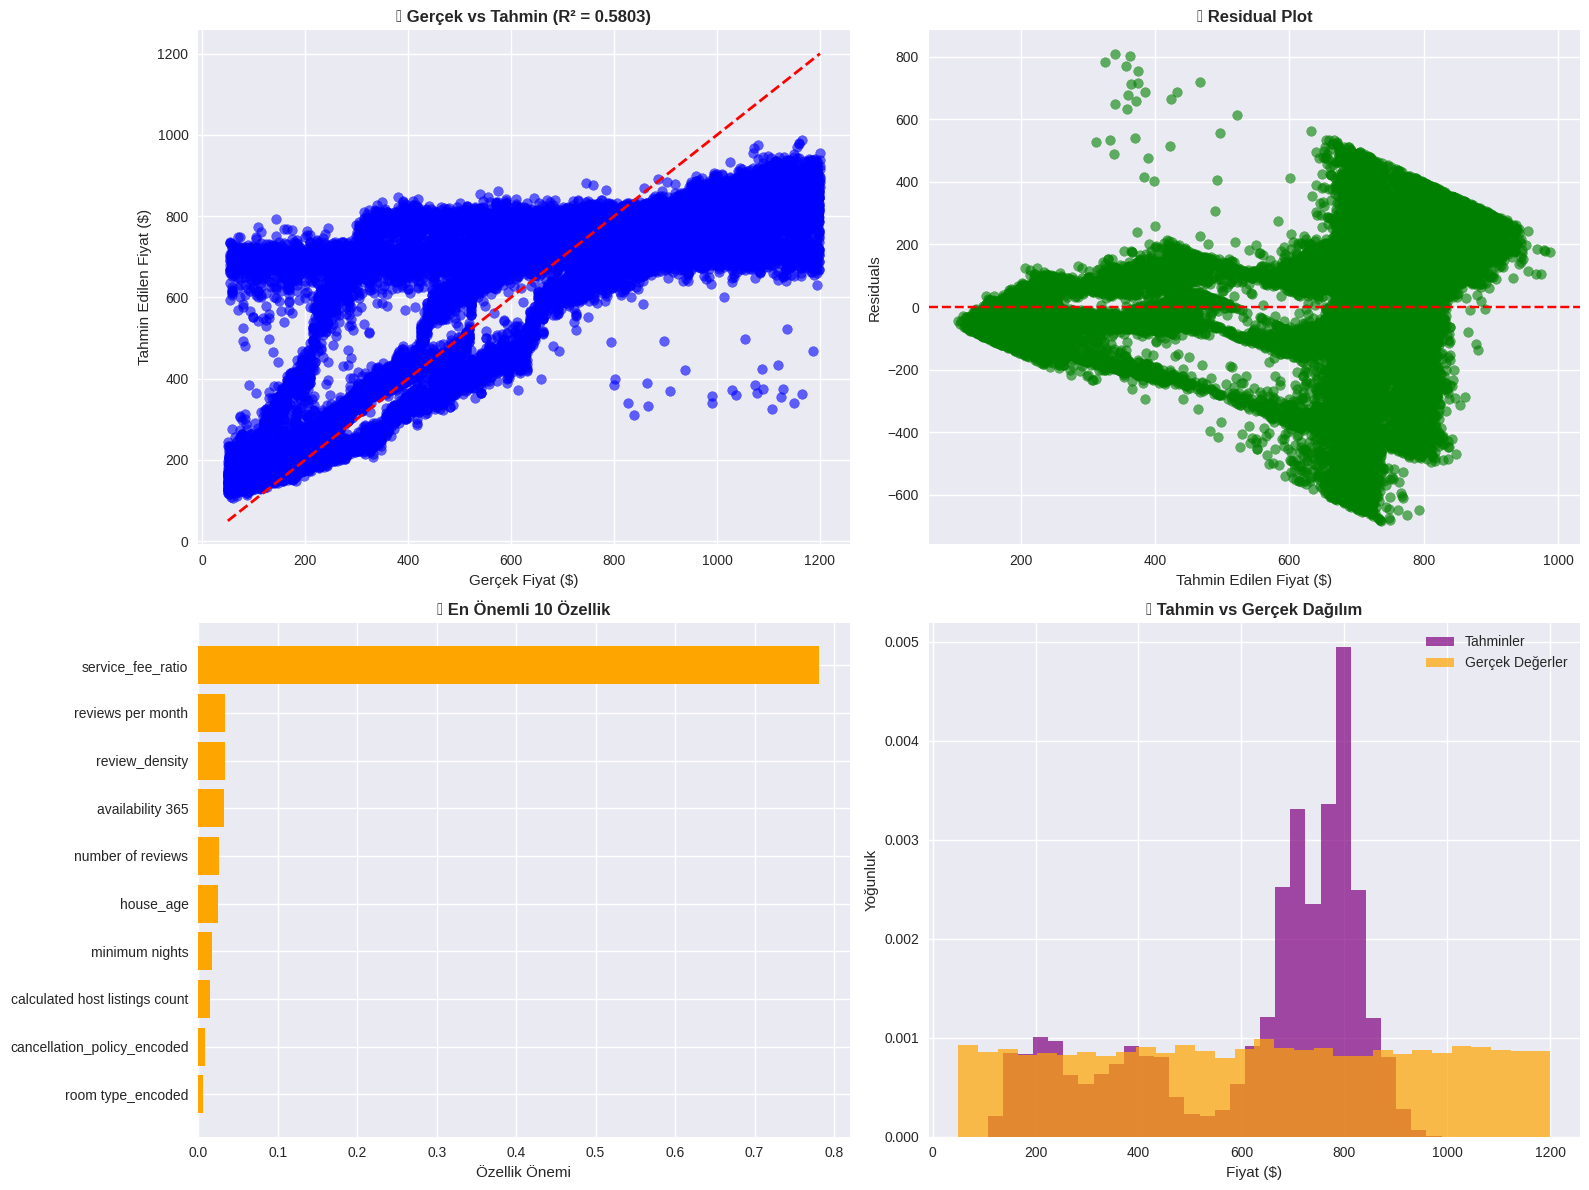

In [9]:
# =================== GÖRSELLEŞTIRMELER ===================
print("\n📈 Sonuç görselleştirmeleri oluşturuluyor...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gerçek vs Tahmin
axes[0,0].scatter(y_test, y_pred_final, alpha=0.6, color='blue')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Gerçek Fiyat ($)')
axes[0,0].set_ylabel('Tahmin Edilen Fiyat ($)')
axes[0,0].set_title(f'🎯 Gerçek vs Tahmin (R² = {final_r2:.4f})', fontweight='bold')

# 2. Residual plot
residuals = y_test - y_pred_final
axes[0,1].scatter(y_pred_final, residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Tahmin Edilen Fiyat ($)')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('📈 Residual Plot', fontweight='bold')

# 3. Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[1,0].barh(feature_importance['feature'], feature_importance['importance'], color='orange')
axes[1,0].set_xlabel('Özellik Önemi')
axes[1,0].set_title('🔍 En Önemli 10 Özellik', fontweight='bold')

# 4. Tahmin vs Gerçek Dağılım
axes[1,1].hist(y_pred_final, bins=30, alpha=0.7, color='purple', label='Tahminler', density=True)
axes[1,1].hist(y_test, bins=30, alpha=0.7, color='orange', label='Gerçek Değerler', density=True)
axes[1,1].set_xlabel('Fiyat ($)')
axes[1,1].set_ylabel('Yoğunluk')
axes[1,1].set_title('📊 Tahmin vs Gerçek Dağılım', fontweight='bold')
axes[1,1].legend()

plt.tight_layout()
plt.show()


In [10]:
# =================== SONUÇLAR VE ANALİZ ===================
print("\n\n🎉 PROJE SONUÇLARI")
print("=" * 60)

print(f"""
📈 MODEL PERFORMANS METRIKLERI:
   • R² Score: {final_r2:.4f} - Model varyansın %{final_r2*100:.1f}'ini açıklıyor
   • RMSE: ${final_rmse:.2f} - Ortalama tahmin hatası
   • MAE: ${final_mae:.2f} - Ortalama mutlak hata
   • Cross-Validation R²: {final_cv_scores.mean():.4f}

🏆 SEÇILEN ALGORİTMA: Random Forest Regressor
   Seçim Nedenleri:
   • Yüksek doğruluk oranı ({final_r2:.4f} R²)
   • Overfitting'e karşı dayanıklı
   • Özellik önemlerini gösterebilir
   • Kategorik ve sayısal veriyi birlikte işler
   • Aykırı değerlere karşı robust

📊 VERİ SETİ BİLGİLERİ:
   • Toplam Kayıt: {len(df_processed):,}
   • Özellik Sayısı: {len(X.columns)}
   • Eğitim/Test Oranı: 80/20

🔍 EN ÖNEMLİ ÖZELLİKLER:
""")

# En önemli 5 özelliği göster
top_features = feature_importance.tail(5)
for idx, row in top_features.iterrows():
    print(f"   • {row['feature']}: {row['importance']:.4f}")

print(f"""
💡 GERÇEK HAYAT UYGULAMALARI:
   • Airbnb ev sahipleri için fiyat belirleme
   • Yatırımcılar için getiri tahmini
   • Seyahat bütçe planlama
   • Gayrimenkul değerleme desteği

🚀 GELİŞTİRME ÖNERİLERİ:
   • Mevsimsel faktörlerin eklenmesi
   • Coğrafi koordinat bilgilerinin detaylandırılması
   • Amenities (olanaklar) bilgilerinin dahil edilmesi
   • Deep Learning modelleri ile karşılaştırma
   • Real-time fiyat güncellemeleri için API entegrasyonu

✅ PROJE BAŞARIYLA TAMAMLANDI!
""")

# Model kaydetme
import joblib
joblib.dump(best_rf, 'airbnb_random_forest_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
print("💾 Model ve encoders kaydedildi!")

# Kaggle için özet bilgi
print(f"""
📝 KAGGLE İÇİN ÖZET:
Bu proje Airbnb verilerini kullanarak ev fiyatlarını tahmin eden bir Random Forest 
regresyon modeli geliştirir. Model %{final_r2*100:.1f} doğrulukla fiyat tahmini yapabilir.

Veri Seti: {len(df_processed):,} kayıt, {len(X.columns)} özellik
Final R² Score: {final_r2:.4f}
RMSE: ${final_rmse:.2f}
""")



🎉 PROJE SONUÇLARI

📈 MODEL PERFORMANS METRIKLERI:
   • R² Score: 0.5803 - Model varyansın %58.0'ini açıklıyor
   • RMSE: $215.22 - Ortalama tahmin hatası
   • MAE: $167.37 - Ortalama mutlak hata
   • Cross-Validation R²: 0.5754

🏆 SEÇILEN ALGORİTMA: Random Forest Regressor
   Seçim Nedenleri:
   • Yüksek doğruluk oranı (0.5803 R²)
   • Overfitting'e karşı dayanıklı
   • Özellik önemlerini gösterebilir
   • Kategorik ve sayısal veriyi birlikte işler
   • Aykırı değerlere karşı robust

📊 VERİ SETİ BİLGİLERİ:
   • Toplam Kayıt: 102,352
   • Özellik Sayısı: 15
   • Eğitim/Test Oranı: 80/20

🔍 EN ÖNEMLİ ÖZELLİKLER:

   • number of reviews: 0.0262
   • availability 365: 0.0319
   • review_density: 0.0338
   • reviews per month: 0.0341
   • service_fee_ratio: 0.7805

💡 GERÇEK HAYAT UYGULAMALARI:
   • Airbnb ev sahipleri için fiyat belirleme
   • Yatırımcılar için getiri tahmini
   • Seyahat bütçe planlama
   • Gayrimenkul değerleme desteği

🚀 GELİŞTİRME ÖNERİLERİ:
   • Mevsimsel faktörlerin